# Evaluación de modelos

## Configuración

### Librerías y funciones

In [51]:
import tensorflow as tf
from keras.metrics import Precision, Recall
from keras.models import Sequential, Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Flatten, MaxPooling2D, Dropout, Conv2D, Resizing, RandomZoom, RandomHeight, RandomWidth
from keras.regularizers import L2
from keras.applications import EfficientNetB0, ResNet50V2, InceptionV3, MobileNet
from keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Configuración del GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-06-04 00:23:43.607086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 00:23:43.678420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 00:23:43.678448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Carga y procesamiento de datos

### Definiciones del dataset

In [5]:
data_dir = 'data_model'
resolution=(256, 455)
num_classes=len(os.listdir(data_dir))

### Carga de datos

In [6]:
data = tf.keras.utils.image_dataset_from_directory(directory=data_dir,
                                                   label_mode='categorical',
                                                   image_size=resolution,
                                                   seed=1)

Found 9213 files belonging to 72 classes.


2023-06-04 00:23:44.200285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 00:23:44.200335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 00:23:44.200348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 00:23:44.954294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-04 00:23:44.954337: I tensorflow/compile

### Escalamiento

In [7]:
data = data.map(lambda x,y:(x/255, y))

### Split

In [8]:
train_size=int(len(data)*0.7)+1
dev_size=int(len(data)*0.15)
test_size=int(len(data)*0.15)

In [9]:
if train_size+dev_size+test_size==len(data):
    print('Split correcto')
else:
    print('Split incorrecto')

Split correcto


In [10]:
train = data.take(train_size)
dev = data.skip(train_size).take(dev_size)
test = data.skip(train_size+dev_size).map(lambda x,y: (tf.image.resize(x, size=(224, 224)), y)).take(test_size)

## Modelos

### Aumento de datos

In [11]:
data_augment=Sequential([
    RandomZoom(0.1),
    RandomHeight(0.1),
    RandomWidth(0.1)
])

### Ejemplo

In [12]:
example_folder=os.listdir(data_dir)[np.random.randint(0,num_classes)]
example_file=os.path.join(data_dir, example_folder, os.listdir(os.path.join(data_dir, example_folder))[np.random.randint(len(os.listdir(os.path.join(data_dir, example_folder))))])
example_file

'data_model/Scope_CH2_deactivate/12_23_15_945_7.png'

(300, 480, 3)

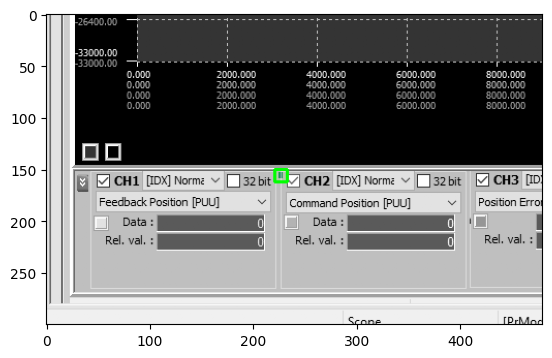

In [13]:
example=plt.imread(example_file)
plt.imshow(example)
example.shape

(324, 450, 3)

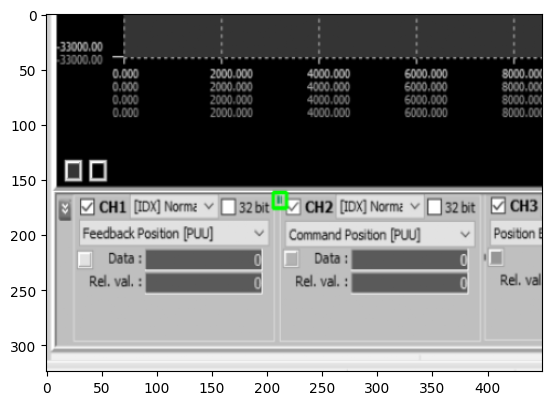

In [14]:
out=data_augment(np.expand_dims(example, axis=0))
plt.imshow(np.squeeze(out))
np.squeeze(out).shape

### Funciones para la creación de modelos

In [15]:
def create_model(model, type='transfer_learning', layers_num=None, dropout_rate=0.3):

    base_model=model(include_top=False)

    if type=='transfer_learning':
        base_model.trainable=False
    elif type=='fine_tuning':
        base_model.trainable=True
        for layer in base_model.layers[:-layers_num]:
            layer.trainable=False
    else:
        return None
    
    inputs=Input(shape=resolution+(3,))
    x=data_augment(inputs, training=True)
    x=Resizing(224, 224)(x)

    x=base_model(x)
    x=Dropout(dropout_rate)(x)
    x=GlobalAveragePooling2D()(x)
    outputs=Dense(num_classes, activation='softmax')(x)
    out_model=Model(inputs, outputs)

    return out_model

def get_final_model(model):

    final_model=Sequential()

    final_model.add(Input(shape=(224,224,3)))
    for layer in model.layers[3:]:
        final_model.add(layer)

    final_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.001))

    return final_model

### Funciones para la evaluación del modelo

In [36]:
def calculate_metrics(test, model):
    pre=Precision()
    re=Recall()
    for batch in test.as_numpy_iterator():
        x,y=batch
        yhat=model.predict(x, verbose=0)
        pre.update_state(y, yhat)
        re.update_state(y, yhat)
    res=model.evaluate(test, verbose=0)
    cat_cross=np.round(res[0],6)
    accuracy=np.round(res[1],6)
    pre=np.round(pre.result(),6)
    re=np.round(re.result(),6)
    f1=np.round((2*re*pre)/(re+pre),6)
    
    return cat_cross,accuracy, pre, re, f1

### Callbacks

In [17]:
#  Parar el modelo tras 5 épocas sin mejora en la 'validation loss'
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [18]:
# Reducir la tasa de aprendizaje tras 10 épocas para un ajuste más fino
def scheduler(epoch, lr):
    if epoch<=10:
        return lr
    else:
        return lr*np.exp(-0.9)

lr_scheduler=LearningRateScheduler(scheduler)

In [19]:
tb_callback=TensorBoard(log_dir='Experimentos')

## MobileNET

### Número de capas

In [20]:
print(f'{len(MobileNet(include_top=False).layers)} layers')

86 layers


In [38]:
df_metrics=pd.DataFrame(columns=['Categorical_crossentropy','Accuracy','Precision','Recall','F1_score'])
history_training=[]

In [39]:
for i in range(10):
    MobileNet_FT=create_model(model=MobileNet, type='fine_tuning', layers_num=50)
    MobileNet_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    history_MobileNet_FT=MobileNet_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler, tb_callback], verbose=0)
    history_training.append(history_MobileNet_FT)
    cc, acc, pre, re, f1=calculate_metrics(test, get_final_model(MobileNet_FT))
    df_temp=pd.DataFrame({'Categorical_crossentropy':cc,'Accuracy':acc,'Precision':pre,'Recall':re,'F1_score':f1}, index=[i])
    df_metrics=pd.concat([df_metrics, df_temp])

2023-06-04 00:39:30.215114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-04 00:42:40.851399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-04 00:46:15.831902: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-04 00:49:07.771254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropo

In [40]:
df_metrics

,Categorical_crossentropy,Accuracy,Precision,Recall,F1_score
0,0.098908,0.972323,0.972182,0.967225,0.969697
1,0.103101,0.969410,0.972202,0.967953,0.970073
2,0.096094,0.970138,0.971429,0.965768,0.968590
3,0.105713,0.967225,0.969186,0.962127,0.965644
4,0.099628,0.973780,0.978006,0.971595,0.974790
5,0.111938,0.968682,0.975789,0.968682,0.972223
6,0.101164,0.967953,0.973626,0.967953,0.970781
7,0.089457,0.971595,0.972141,0.965768,0.968944
8,0.092977,0.975237,0.978676,0.969410,0.974021
9,0.088085,0.975237,0.977273,0.970867,0.974059


In [46]:
df_metrics.to_excel('Evaluación.xlsx', index=False)

In [41]:
df_metrics.mean()

Categorical_crossentropy    0.098707
Accuracy                    0.971158
Precision                   0.974051
Recall                      0.967735
F1_score                    0.970882
dtype: float64

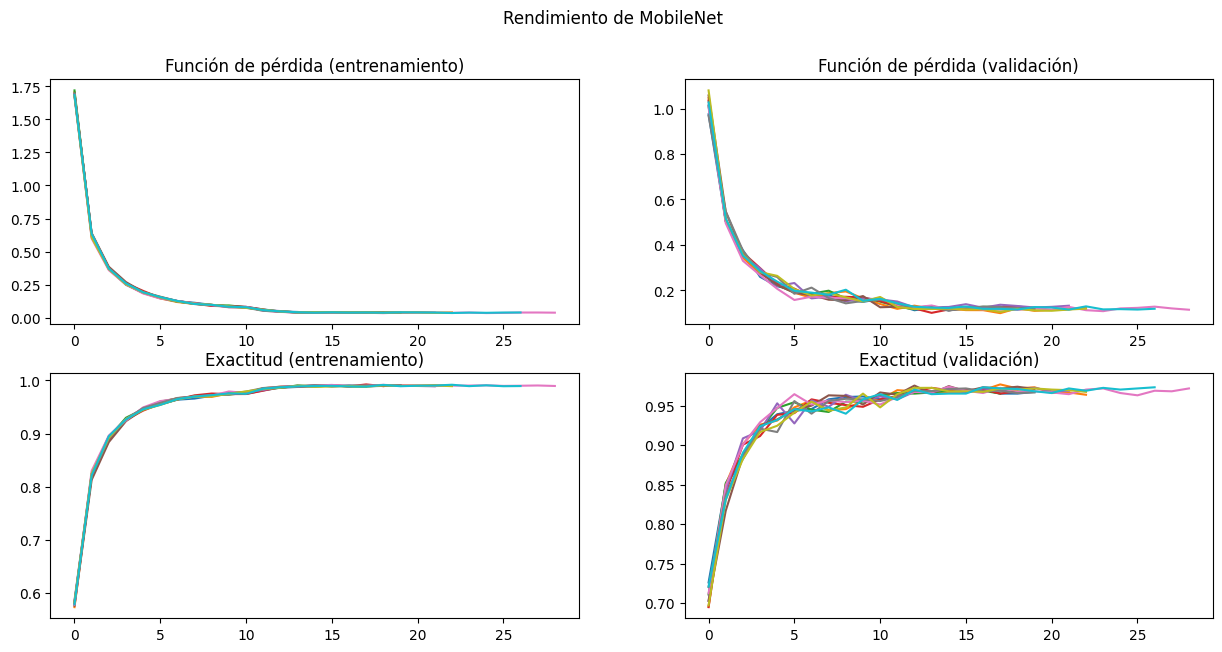

In [47]:
fig, [[ax1,ax2],[ax3, ax4]] = plt.subplots(2,2)
for j in range(10):
    ax1.plot(history_training[j].history['loss'])
ax1.set_title('Función de pérdida (entrenamiento)')

for j in range(10):
    ax2.plot(history_training[j].history['val_loss'])
ax2.set_title('Función de pérdida (validación)')

for j in range(10):
    ax3.plot(history_training[j].history['accuracy'])
ax3.set_title('Exactitud (entrenamiento)')

for j in range(10):
    ax4.plot(history_training[j].history['val_accuracy'])
ax4.set_title('Exactitud (validación)')

fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('Rendimiento de MobileNet');

In [48]:
labels=os.listdir(data_dir)

In [49]:
yhat=np.array([])
ytrue=np.array([])

for x,y in test.as_numpy_iterator():
    yhat = np.concatenate([yhat, np.argmax(get_final_model(MobileNet_FT).predict(x, verbose=0), axis = -1)])
    ytrue = np.concatenate([ytrue, np.argmax(y, axis=-1)])

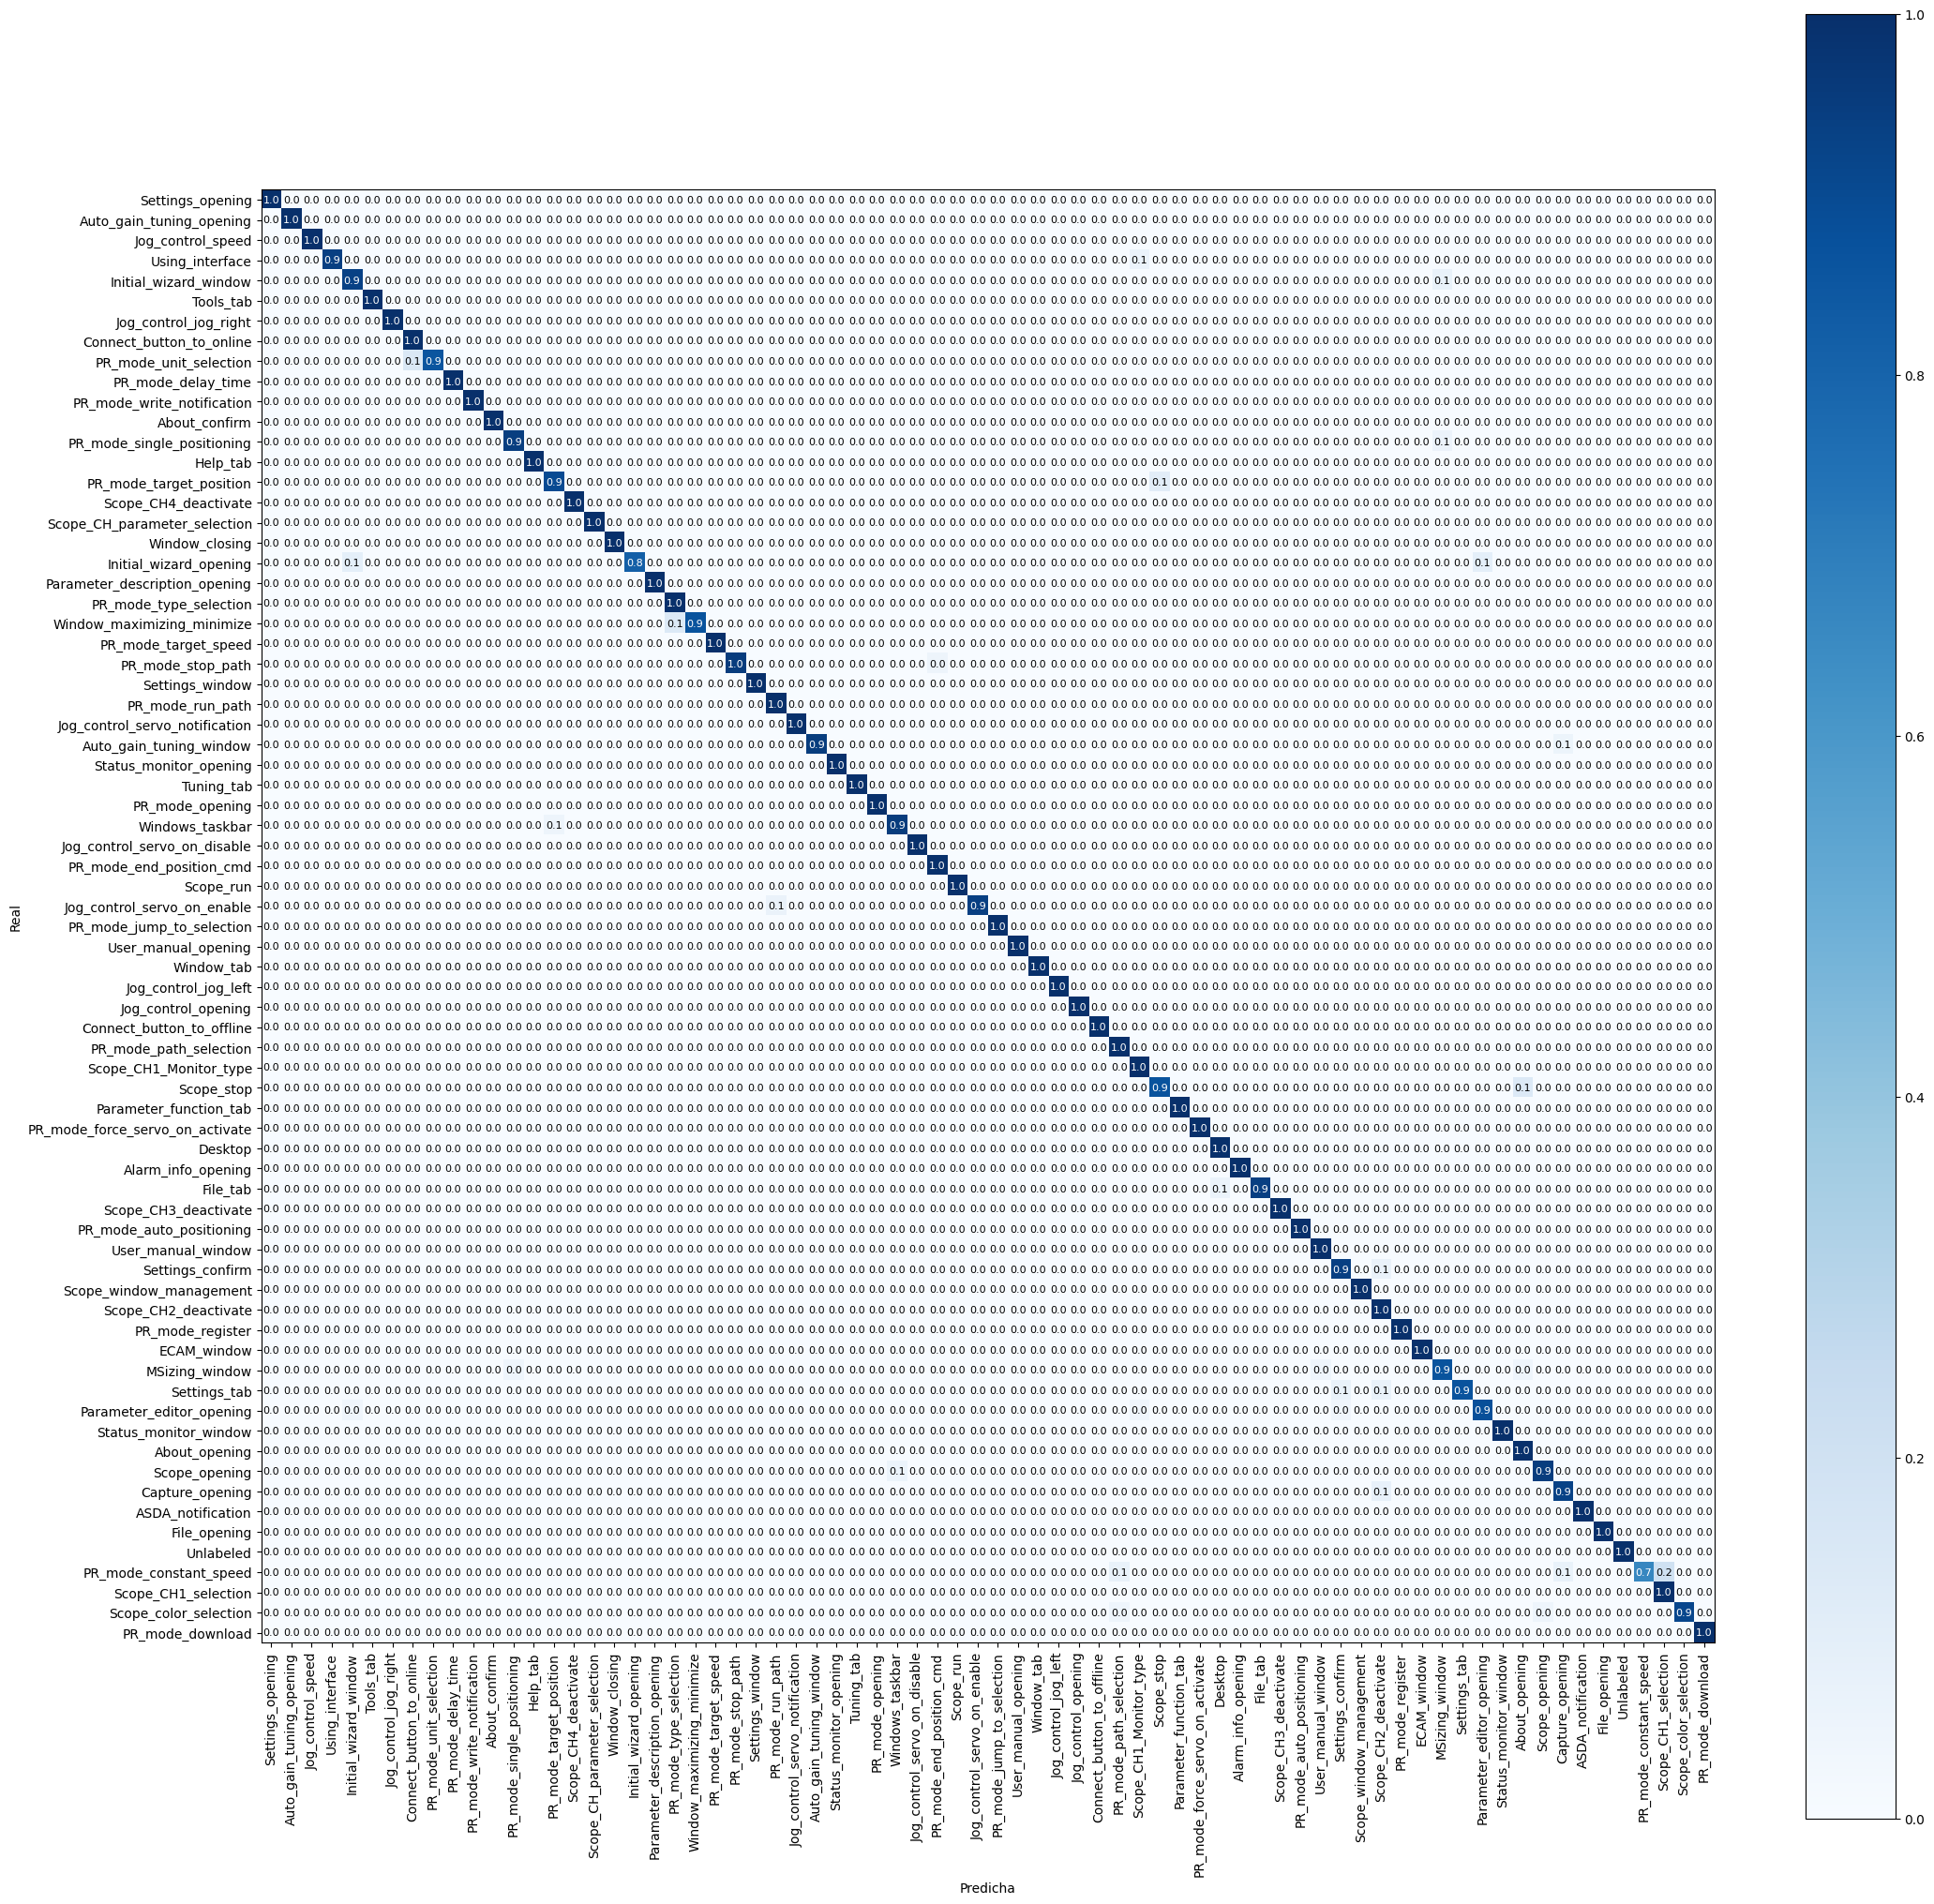

In [52]:
cm = confusion_matrix(ytrue, yhat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels,
       yticklabels=labels,
       xlabel='Predicha',
       ylabel='Real')

thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, format(cm_normalized[i, j], '.1f'),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black",
                fontsize=8)

        
plt.xticks(rotation='vertical')

fig.set_figheight(25)
fig.set_figwidth(25)
plt.show()